**HyperTS supports univariate and multivariate time series forecsting tasks.**

**In this NoteBook, we will use HyperTS to do a time series forecasting task.**

###  Step 1: Let`s still use **Network Traffic** dataset, import it and do EDA.

In [1]:
from hyperts.datasets import load_network_traffic

Load Data:

In [2]:
df = load_network_traffic()

In [3]:
df.head()

,TimeStamp,Var_1,Var_2,Var_3,Var_4,Var_5,Var_6,HourSin,WeekCos,CBWD
0,2021-03-01 00:00:00,0.7534,3.375,10.195,1.4490,19174.977,286443.880,0.000000,1.0,NW
1,2021-03-01 01:00:00,0.3376,2.414,3.920,0.4065,7529.263,178930.450,0.258819,1.0,NW
2,2021-03-01 02:00:00,0.2032,1.654,3.318,0.2142,3310.539,42296.164,0.500000,1.0,NW
3,2021-03-01 03:00:00,0.2420,1.393,3.148,0.2312,4535.464,26220.232,0.707107,1.0,NW
4,2021-03-01 04:00:00,0.1940,1.429,3.215,0.2157,2732.911,27990.348,0.866025,1.0,NW


From the table, we can see that:
- timestamp column name: 'TimeStamp';
- target column names: ['Var_1', 'Var_2', 'Var_3', 'Var_4', 'Var_5', 'Var_6'];
- covariable column names: ['HourSin', 'WeekCos', 'CBWD'];
- time freq: 'H'.

According to the value of the target variables, there are dimensional differences between variables.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2878 entries, 0 to 2877
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TimeStamp  2878 non-null   object 
 1   Var_1      2878 non-null   float64
 2   Var_2      2878 non-null   float64
 3   Var_3      2877 non-null   float64
 4   Var_4      2877 non-null   float64
 5   Var_5      2877 non-null   float64
 6   Var_6      2877 non-null   float64
 7   HourSin    2878 non-null   float64
 8   WeekCos    2878 non-null   float64
 9   CBWD       2878 non-null   object 
dtypes: float64(8), object(2)
memory usage: 225.0+ KB


info shows that this data has missing values and TimeStamp is of type object.

In [5]:
import pandas as pd

time_start = df['TimeStamp'].tolist()[0]
time_end = df['TimeStamp'].tolist()[-1]

complete_time_df = pd.date_range(start=time_start, end=time_end, freq='H')

complete_time_length = len(complete_time_df)
actual_time_length = len(df)

print('time start: {} - time end: {}'.format(time_start, time_end))
print('complete_time_length: {} - actual_time_length: {}'.format(complete_time_length, actual_time_length))

time start: 2021-03-01 00:00:00 - time end: 2021-06-30 23:00:00
complete_time_length: 2928 - actual_time_length: 2878


According to statistics, if the start time of the time series is **2021-03-01 00:00:00** and the end time is **2021-06-30 23:00:00**, with hour (H) as the time frequency, there are **2928** time points in the natural series, but **2878** time points in the actual data. Therefore, during the collection of this data, some time segment values may be lost due to some factors.

Now, we select variable Var_3 as the target variable to do a **univariate forecasting task**.

**Task objective:** To forecast future infomation at 168 time points based on historical data.

Split train_data and test_data

For split train_data and test_data, we can use ```sklearn.model_selection``` build-in ```train_test_split```. Here HyperTS alse provides the corresponding function ```temporal_train_test_split``` for use.

In [6]:
from hyperts.toolbox import temporal_train_test_split

df = df.drop(['Var_1', 'Var_2','Var_4','Var_5','Var_6'], axis=1)

train_data, test_data = temporal_train_test_split(df, test_horizon=168)

In [7]:
train_data.head()

,TimeStamp,Var_3,HourSin,WeekCos,CBWD
0,2021-03-01 00:00:00,10.195,0.000000,1.0,NW
1,2021-03-01 01:00:00,3.920,0.258819,1.0,NW
2,2021-03-01 02:00:00,3.318,0.500000,1.0,NW
3,2021-03-01 03:00:00,3.148,0.707107,1.0,NW
4,2021-03-01 04:00:00,3.215,0.866025,1.0,NW


In [8]:
test_data.tail()

,TimeStamp,Var_3,HourSin,WeekCos,CBWD
2873,2021-06-30 18:00:00,10.530,-1.000000,-0.222521,NW
2874,2021-06-30 20:00:00,12.890,-0.866025,-0.222521,NW
2875,2021-06-30 21:00:00,12.920,-0.707107,-0.222521,SE
2876,2021-06-30 22:00:00,9.016,-0.500000,-0.222521,cv
2877,2021-06-30 23:00:00,9.970,-0.258819,-0.222521,NE


Visulization of train_data curve and test_data curve.

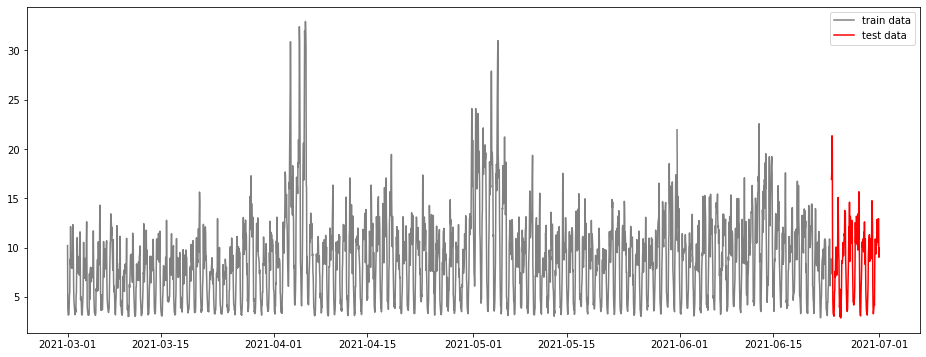

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
plt.plot(pd.to_datetime(train_data['TimeStamp']), train_data['Var_3'], c='gray', label='train data')
plt.plot(pd.to_datetime(test_data['TimeStamp']), test_data['Var_3'], c='red', label='test data')
plt.legend()
plt.show()

###  Step 2: Create experiments and search for models.

Configure some parameters for experiment. For details, see make_experiment comments.

- For convenience and to avoid defining parameter writing errors, we can use the ```consts``` in ```hyperts.utils``` to get the qualified variable names.
- In order to search for better models, we increased the number of searches by adjusting the parameter ```max_Trials```.
- To avoid getting stuck in long rounds of invalid searches, we added ```early_stopping_rounds``` to limit the number of rounds and ```early_stopping_time_limit``` to control the total running time.
- HyperTS is evolutionary search by default, we can change it to Monte Carlo Tree Search by adjusting the parameter ```searcher```.

In [10]:
from hyperts.utils import consts
from hyperts import make_experiment

In [11]:
experiment = make_experiment(train_data=train_data.copy(),
                task=consts.Task_UNIVARIATE_FORECAST,
                mode=consts.Mode_STATS,
                timestamp='TimeStamp',
                covariables=['HourSin', 'WeekCos', 'CBWD'],
                max_trials=30,
                early_stopping_rounds=10,
                early_stopping_time_limit=3600,
                reward_metric='mae',
                searcher='mcts')

model = experiment.run()

### Step 3: Gets pipeline model parameters.

In [12]:
model.get_pipeline_params()

<bound method Pipeline.get_params of Pipeline(steps=[('data_preprocessing',
                 TSFDataPreprocessStep(covariate_cols=['HourSin', 'WeekCos',
                                                       'CBWD'],
                                       covariate_data_clean_args={'correct_object_dtype': False,
                                                                  'drop_columns': None,
                                                                  'drop_constant_columns': True,
                                                                  'drop_duplicated_columns': False,
                                                                  'drop_idness_columns': True,
                                                                  'drop_label_nan_rows': True,
                                                                  'int_convert_to': 'float',
                                                                  'nan_chars': None,
                                 

### Step 4: Forecast on test data (unknown data).

In [13]:
X_test, y_test = model.split_X_y(test_data.copy())

In [14]:
X_test.head()

,TimeStamp,HourSin,WeekCos,CBWD
2710,2021-06-23 19:00:00,-0.965926,-0.222521,NW
2711,2021-06-23 20:00:00,-0.866025,-0.222521,cv
2712,2021-06-23 21:00:00,-0.707107,-0.222521,NW
2713,2021-06-23 22:00:00,-0.500000,-0.222521,NW
2714,2021-06-23 23:00:00,-0.258819,-0.222521,NW


In [15]:
forecast = model.predict(X_test)
forecast.head()

,TimeStamp,Var_3
2710,2021-06-23 19:00:00,11.493317
2711,2021-06-23 20:00:00,11.875371
2712,2021-06-23 21:00:00,11.558684
2713,2021-06-23 22:00:00,10.042594
2714,2021-06-23 23:00:00,7.661004


The ```predict``` of HyperTS will output a DataFrame containing the predicted values of the target variables at all times in X_test.

### Step 5: Evaluation.

During the evaluation process, we can use the ```evaluate``` function of HyperTS, which has some evaluation metrics built in by default for various tasks.

In [16]:
results = model.evaluate(y_true=y_test, y_pred=forecast)
results

,Metirc,Score
0,mae,1.6534
1,mse,4.7529
2,rmse,2.1801
3,mape,0.2001
4,smape,0.1841


Set your own metrics.

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

results = model.evaluate(y_true=y_test, y_pred=forecast, metrics=[mean_absolute_error, mean_squared_error, 'mape'])
results.head()

,Metirc,Score
0,mean_absolute_error,1.6534
1,mean_squared_error,4.7529
2,mape,0.2001


### Step6: Visualize the forecast curve.

HyperTS supports two ways to draw forecast curves: interactive (plotly installation required) and non-interactive (matplotlib installation required). The default is interactive. If you want to draw non-interactive, you can set ```interactive=False```.

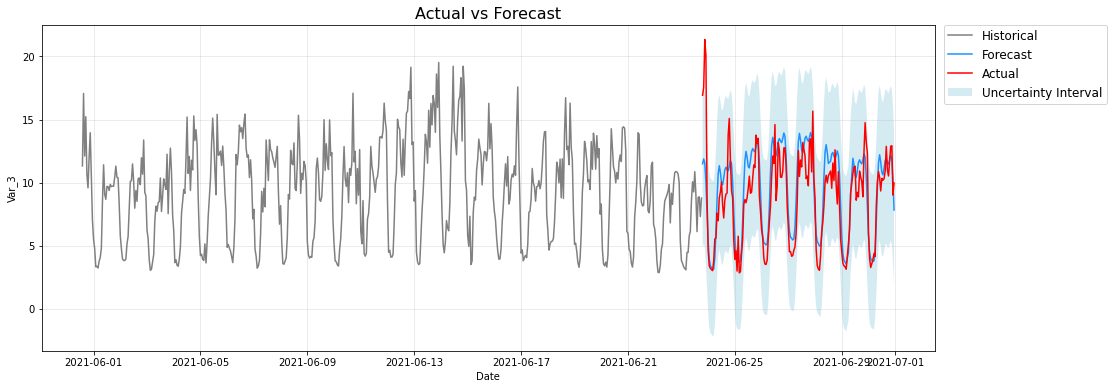

In [18]:
model.plot(forecast=forecast, actual=test_data, interactive=False)